In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt # module for plotting 
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


## **USING LSTM**

Reading the dataset

In [114]:
import holidays

for date, name in sorted(holidays.IND(state='TN', years=2018).items()):
  print(date, name)



2018-01-01 New Year
2018-01-14 Makar Sankranti / Pongal
2018-01-26 Republic Day
2018-05-01 Labour Day
2018-08-15 Independence Day
2018-10-02 Gandhi Jayanti
2018-12-25 Christmas


In [115]:

dataframe = pd.read_excel("/content/drive/My Drive/dailySolarWithFeatures.xlsx")
#dataframe.info()
dataframe['weekday'] = dataframe['TimeReviewed'].dt.dayofweek
dataframe['day_type'] = np.zeros(len(dataframe))
dataframe['day_type'][(dataframe['weekday']==6)|(dataframe['TimeReviewed']=='2018-1-1')|(dataframe['TimeReviewed']=='2018-1-14')|(dataframe['TimeReviewed']=='2018-1-26')|(dataframe['TimeReviewed']=='2018-5-1')|(dataframe['TimeReviewed']=='2018-8-15')|(dataframe['TimeReviewed']=='2018-10-2')|(dataframe['TimeReviewed']=='2018-12-25')|(dataframe['TimeReviewed']=='2019-1-1')|(dataframe['TimeReviewed']=='2019-1-14')|(dataframe['TimeReviewed']=='2019-1-26')|(dataframe['TimeReviewed']=='2019-5-1')]=1
dataframe.info()
dataframe.to_csv("/content/drive/My Drive/dailySolarWithFeatures.csv")
dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 8 columns):
TimeReviewed                   506 non-null datetime64[ns]
Solar_Power_Generation( Kw)    506 non-null float64
LUX Level(lx)                  506 non-null int64
Panel_Temp( C)                 506 non-null float64
Temp( C)                       506 non-null float64
Solar Irradiance(W/m2)         506 non-null int64
weekday                        506 non-null int64
day_type                       506 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 31.7 KB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,TimeReviewed,Solar_Power_Generation( Kw),LUX Level(lx),Panel_Temp( C),Temp( C),Solar Irradiance(W/m2),weekday,day_type
0,2018-01-01,0.344000,54,0.000000,26.000000,0,0,1.0
1,2018-01-02,38.132000,59,60.200001,26.000000,9811,1,0.0
2,2018-01-03,36.706001,38,60.799999,26.000000,9057,2,0.0
3,2018-01-04,27.841999,49,58.400002,26.000000,9289,3,0.0
4,2018-01-05,35.297001,52,54.200001,26.000000,8579,4,0.0
5,2018-01-06,33.577000,47,55.700001,26.000000,8359,5,0.0
6,2018-01-07,10.127000,45,53.599998,26.000000,7776,6,1.0
7,2018-01-08,34.333000,50,51.400002,26.000000,8551,0,0.0
8,2018-01-09,37.701000,52,52.500000,26.000000,8856,1,0.0
9,2018-01-10,31.559000,38,43.700001,26.000000,10812,2,0.0


Converting the time series to supervised learning model.

In [126]:
#The following code takes the past data(t-1) and predicts the current value
#converting the time series model into a supervised model for fitting the data into the LSTM
#n_in<- number of inputs required(1)
#n_in<- number of outputs required(1)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))# shift is a pandas function-create columns of lag observations as well as columns of forecast observations for a time series dataset in a supervised learning format.
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]# we find value(t-1) for each column
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# load dataset
dataset = pd.read_csv('/content/drive/My Drive/cleandailySolarWithFeatures .csv', header=0, index_col=0)
data = dataset[dataset.day_type != 1]
data.reset_index()
np.random.seed(107)
values = data[['Solar_Power_Generation( Kw)','LUX Level(lx)','Panel_Temp( C)','Temp( C)','Solar Irradiance(W/m2)']].values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
#drop the values you dont want to predict
reframed.drop(reframed.columns[[6,7,8,9]], axis=1, inplace=True)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t)
1,0.648634,0.904762,0.889217,0.058648,0.732273,0.612056
2,0.612056,0.571429,0.898080,0.058648,0.675996,0.384686
3,0.384686,0.746032,0.862629,0.058648,0.693312,0.575914
4,0.575914,0.793651,0.800591,0.058648,0.640319,0.531794
5,0.531794,0.714286,0.822747,0.058648,0.623899,0.551186
6,0.551186,0.761905,0.759232,0.058648,0.638230,0.637578
7,0.637578,0.793651,0.775480,0.058648,0.660994,0.480031
8,0.480031,0.571429,0.645495,0.058648,0.806986,0.640375
9,0.640375,0.746032,0.824225,0.000000,0.787730,0.164191
10,0.164191,0.428571,0.621861,0.058648,0.340722,0.423240


In [127]:
 values = reframed.values

n_train_time = 300 #training size is taken for 1 year (2017/26/12 to 2018/26/12)
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]#takes the first 5 columns
test_X, test_y = test[:, :-1], test[:, -1]#takes the last column.
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].
 
test_y


(300, 1, 5) (300,) (124, 1, 5) (124,)


array([0.64032316, 0.53323066, 0.53066564, 0.40846476, 0.35585484,
       0.6624856 , 0.66399896, 0.46692315, 0.6732589 , 0.59879434,
       0.56334484, 0.5436963 , 0.62393224, 0.6072849 , 0.4758753 ,
       0.44119534, 0.5080544 , 0.60569453, 0.60569453, 0.49908933,
       0.45096835, 0.5432602 , 0.5467231 , 0.5189432 , 0.5316659 ,
       0.45366165, 0.49239454, 0.5293062 , 0.45591894, 0.48149285,
       0.54582536, 0.46661535, 0.30460432, 0.41187635, 0.58124924,
       0.6290368 , 0.6001539 , 0.5424651 , 0.6632807 , 0.6109786 ,
       0.5944338 , 0.6013595 , 0.6012312 , 0.5338464 , 0.58081305,
       0.5770681 , 0.6282929 , 0.5997691 , 0.6061305 , 0.54959595,
       0.64163136, 0.58504546, 0.52030265, 0.48162112, 0.56580734,
       0.51907146, 0.56757724, 0.5671669 , 0.5292548 , 0.53943825,
       0.49552384, 0.48380145, 0.5739387 , 0.579864  , 0.56498647,
       0.7286649 , 0.58704627, 0.5979736 , 0.57365656, 0.56160057,
       0.5653199 , 0.5322304 , 0.53646266, 0.51722455, 0.55387

LSTM Model

In [128]:
#used LSTM model with 100 neurons presents
train_X.shape[1]
model = Sequential()
model.add(LSTM(1000,activation='relu',input_shape=(train_X.shape[1], train_X.shape[2])))#train_X.shape[1]= time_steps,train_X.shape[2]= number of features
model.add(Dropout(0.5))
#model.add(LSTM(128,activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1000)              4024000   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1001      
Total params: 4,025,001
Trainable params: 4,025,001
Non-trainable params: 0
_________________________________________________________________


In [129]:
early_stopping_monitor = EarlyStopping(patience=4)
history = model.fit(train_X, train_y, epochs=30, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False,callbacks=[early_stopping_monitor])
#the loss is low at the same time the accuracy is also low.

Train on 300 samples, validate on 124 samples
Epoch 1/30
 - 4s - loss: 0.3705 - val_loss: 0.2427
Epoch 2/30
 - 1s - loss: 0.2476 - val_loss: 0.1438
Epoch 3/30
 - 1s - loss: 0.1420 - val_loss: 0.0654
Epoch 4/30
 - 1s - loss: 0.0646 - val_loss: 0.0195
Epoch 5/30
 - 1s - loss: 0.0270 - val_loss: 0.0119
Epoch 6/30
 - 1s - loss: 0.0284 - val_loss: 0.0192
Epoch 7/30
 - 1s - loss: 0.0353 - val_loss: 0.0163
Epoch 8/30
 - 1s - loss: 0.0290 - val_loss: 0.0113
Epoch 9/30
 - 1s - loss: 0.0236 - val_loss: 0.0114
Epoch 10/30
 - 1s - loss: 0.0259 - val_loss: 0.0129
Epoch 11/30
 - 1s - loss: 0.0267 - val_loss: 0.0126
Epoch 12/30
 - 1s - loss: 0.0241 - val_loss: 0.0114


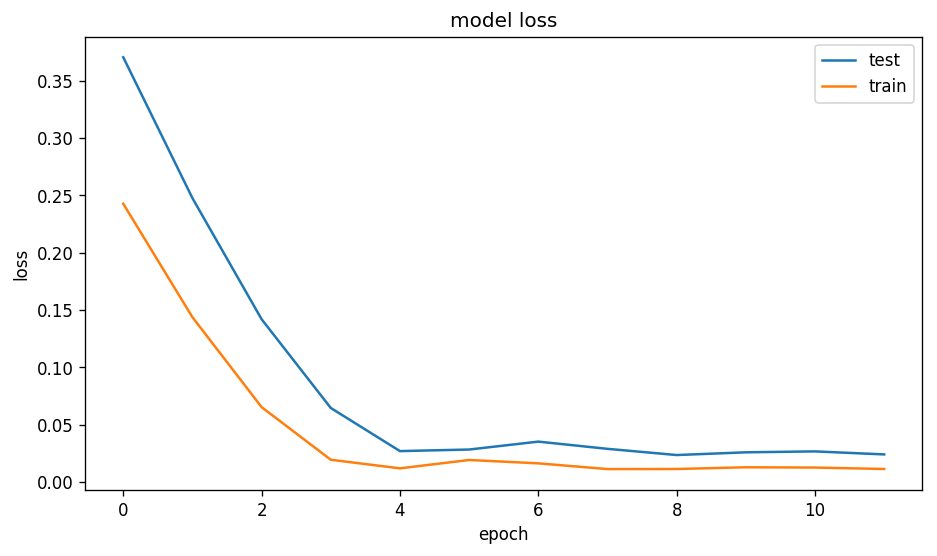

In [130]:
import matplotlib.pyplot as plt # module for plotting 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['test', 'train'], loc='upper right')
plt.show()
#. Difficulty in improving accuracy, extreme overfitting

In [0]:

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],test_X.shape[2]))
test_X.shape
#invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -4:]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
#invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]



In [132]:
inv_yhat

array([33.79657 , 33.003387, 36.78763 , 36.29143 , 32.999126, 31.242466,
       36.51593 , 36.722363, 36.117577, 36.52626 , 36.45571 , 35.544243,
       35.93256 , 36.18367 , 36.235813, 35.853954, 34.78868 , 35.155964,
       35.80757 , 35.4839  , 33.898384, 35.386814, 35.582825, 36.160416,
       35.149574, 35.557507, 34.64581 , 35.926224, 35.629173, 34.115932,
       33.820187, 34.896626, 34.766376, 28.653887, 25.155014, 36.120914,
       35.743073, 36.258644, 35.32518 , 35.934658, 35.686947, 35.314796,
       36.137905, 36.49163 , 35.609703, 36.151943, 34.975258, 36.272823,
       35.644432, 35.876244, 36.151245, 35.71963 , 35.24908 , 34.355713,
       34.435524, 35.488804, 34.31497 , 35.115494, 34.27059 , 33.735634,
       33.717068, 33.050907, 33.78969 , 34.559673, 34.565586, 34.96687 ,
       36.4624  , 35.568787, 35.091194, 36.05286 , 35.191135, 35.71022 ,
       34.834442, 34.85554 , 34.817593, 35.155155, 35.1474  , 35.55813 ,
       34.83342 , 34.550755, 34.546787, 35.019844, 

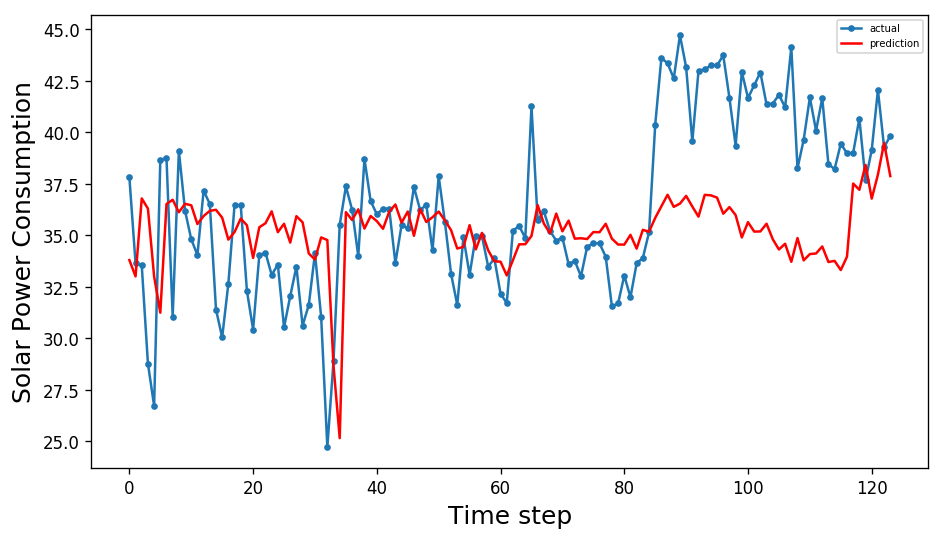

In [133]:

aa=[x for x in range(len(inv_y))]
plt.plot(aa, inv_y[:,], marker='.', label="actual")
plt.plot(aa, inv_yhat[:,], 'r', label="prediction")
plt.ylabel('Solar Power Consumption', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=6)
plt.savefig('/content/drive/My Drive/pred_graph.png',dpi=100)
plt.show()



In [138]:
error_list = list()
predicted = list()
expected = list()
for i in range (len(test_y)):
  error = 100*abs(inv_yhat[i]-inv_y[i])/inv_y[i]
  print('predicted=%f, expected=%f' % (inv_yhat[i], inv_y[i]),'error=%f',error)
  predicted.append(inv_yhat[i])
  expected.append(inv_y[i])

error_list.append(error)
Result_df = pd.DataFrame()
Result_df['Predicted']= predicted
Result_df['Observed']= expected

Result_df.to_csv('/content/drive/My Drive/RESULT.csv')

predicted=33.796570, expected=37.807999 error=%f 10.610000464124207
predicted=33.003387, expected=33.632996 error=%f 1.8719954704079356
predicted=36.787628, expected=33.533001 error=%f 9.70574400131961
predicted=36.291431, expected=28.768999 error=%f 26.147702605825895
predicted=32.999126, expected=26.718000 error=%f 23.50896745821134
predicted=31.242466, expected=38.672001 error=%f 19.211664103445056
predicted=36.515930, expected=38.730999 error=%f 5.719110982764967
predicted=36.722363, expected=31.047998 error=%f 18.276102735129967
predicted=36.117577, expected=39.091999 error=%f 7.608775521376288
predicted=36.526260, expected=36.188995 error=%f 0.931954621235056
predicted=36.455711, expected=34.806999 error=%f 4.736725933826558
predicted=35.544243, expected=34.041000 error=%f 4.415976253647052
predicted=35.932560, expected=37.168999 error=%f 3.3265323088007244
predicted=36.183670, expected=36.520000 error=%f 0.920948547652222
predicted=36.235813, expected=31.396999 error=%f 15.41170

In [137]:
print('\n Mean Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')


 Mean Error in Predicting Test Case Articles : 4.902102  %
